In [ ]:
#wget script
from odc_colab import odc_colab_init, populate_db
odc_colab_init(use_defaults=True, download_db=True); populate_db('db_dump.tar.xz')

<a id="top"></a>
# Cloud-Filtered Custom Mosaics

<hr>

# Notebook Summary

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data  
Geomedian = Australian median product with improved spectral consistency  
Most-Recent = most-recent clear pixel  
Max-NDVI = maximum vegetation response

Users should review the [DCAL Cloud Statistics notebook](DCAL_Cloud_Statistics.ipynb) for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses. In many cases, cloud contamination will create poor mosaics. With a careful review of the cloud coverage over a given region and time period, it is possible to improve the mosaics and avoid false outputs.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics](#mosaics)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.vegetation import NDVI
from utils.data_cube_utilities.dc_mosaic import \
    create_median_mosaic, create_hdmedians_multiple_band_mosaic, \
    create_mosaic, create_min_max_var_mosaic
#     create_max_ndvi_mosaic,
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


platform                      name
id                                     
12  LANDSAT_7  ls7_collections_sr_scene
13  LANDSAT_7          ls7_ledaps_ghana
17  LANDSAT_7          ls7_ledaps_kenya
18  LANDSAT_7        ls7_ledaps_senegal
16  LANDSAT_7   ls7_ledaps_sierra_leone
19  LANDSAT_7       ls7_ledaps_tanzania
31  LANDSAT_7        ls7_ledaps_vietnam

In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


platform                      name
id                                     
7   LANDSAT_8  ls8_collections_sr_scene
9   LANDSAT_8           ls8_lasrc_ghana
10  LANDSAT_8           ls8_lasrc_kenya
11  LANDSAT_8         ls8_lasrc_senegal
8   LANDSAT_8    ls8_lasrc_sierra_leone
15  LANDSAT_8        ls8_lasrc_tanzania

**Choose product**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_usgs_sr_scene"
# platform = "LANDSAT_7"

product = "ls8_lasrc_tanzania"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-11.999019059879926, -0.0001356388440351325)
Longitude Extents: (28.998784571651935, 40.99806659404953)
Time Extents: ['2013-04-12', '2018-01-01']


**Visualize the available area**

In [6]:
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
latitude = (-4.1, -3.9) 
longitude = (34.5, 34.7) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Tano-Offin Forest - Ghana
# latitude = (6.5814, 6.8978 ) 
# longitude = (-2.2955, -1.9395) 

# Vietnam
# latitude = (10.9358, 11.0358)
# longitude = (107.1899, 107.2899)

# Time Period
time_extents = ('2017-01-01', '2017-12-31')

**Visualize the selected area**

In [8]:
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [9]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:      (latitude: 738, longitude: 739, time: 23)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T07:50:22 ... 2017-12-19T07:...
  * latitude     (latitude) float64 -3.9 -3.9 -3.901 -3.901 ... -4.099 -4.1 -4.1
  * longitude    (longitude) float64 34.5 34.5 34.5 34.5 ... 34.7 34.7 34.7 34.7
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 5980 5971 5914 ... 583 517
    green        (time, latitude, longitude) int16 5834 5823 5775 ... 631 576
    blue         (time, latitude, longitude) int16 5739 5708 5704 ... 357 253
    nir          (time, latitude, longitude) int16 6355 6346 6317 ... 3040 2991
    swir1        (time, latitude, longitude) int16 5786 5767 5704 ... 2224 2333
    swir2        (time, latitude, longitude) int16 4996 4970 4868 ... 1277 1368
    pixel_qa     (time, latitude, longitude) int32 992 992 992 ... 322 322 322
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

>### Masking out Clouds

In [11]:
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Mosaics [&#9652;](#top)</span>

In [12]:
common_rgb_params = dict(bands=['swir2', 'nir', 'green'], 
                         imshow_kwargs=dict(vmin=0, vmax=4000),
                         width=10)

> **Median Mosaic**  
>  Masks clouds from imagery using the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.

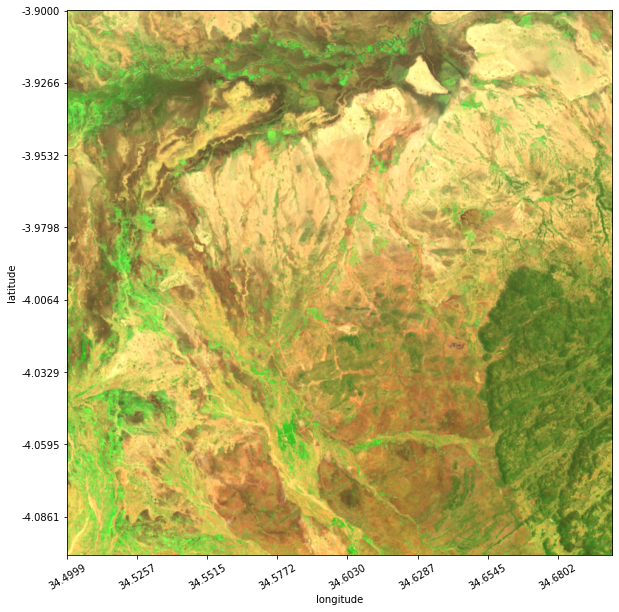

In [13]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(median_composite, **common_rgb_params)
plt.show()

> **Geomedian Mosaic**  
>  Masks clouds from imagery using the geomedian-valued cloud-free pixels in the time series, which maintains the spectral band relationships. 
> That is, this is a median through time for all bands considered collectively rather than separately, as is the case in a median mosaic.
> This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

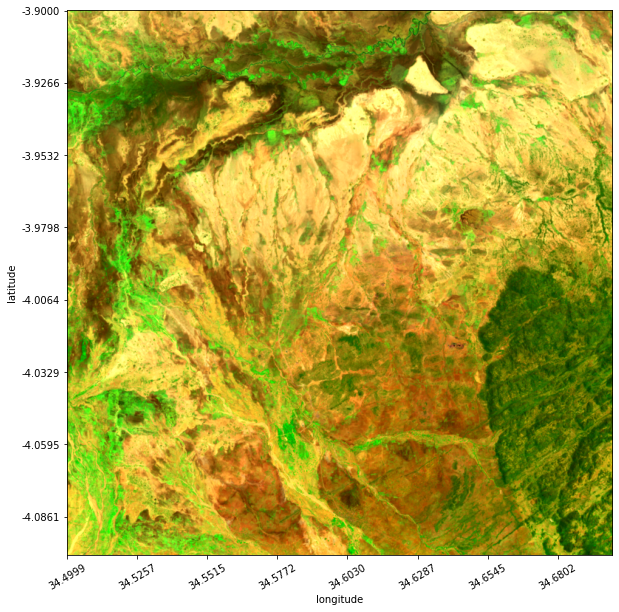

In [14]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

geomedian_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(geomedian_composite, **common_rgb_params)
plt.show()

> **Most Recent and Least Recent Mosaic**  
>  Masks clouds from imagery using the most or least recent cloud-free pixels in the time series. 

**Most Recent Mosaic**

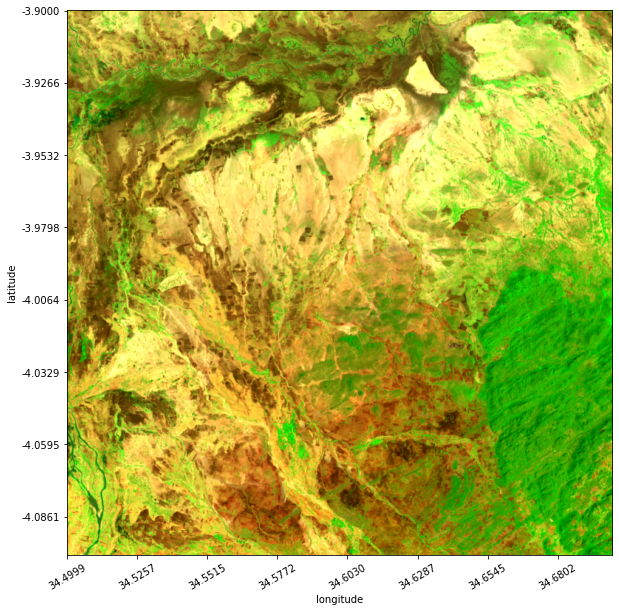

In [15]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)
rgb(most_recent_composite, **common_rgb_params)
plt.show()

**Least Recent Mosaic**

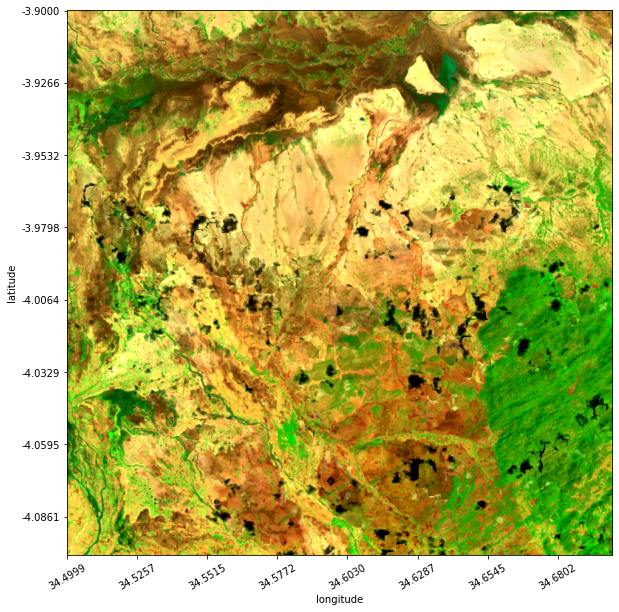

In [16]:
least_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values, reverse_time=True)
rgb(least_recent_composite, **common_rgb_params)
plt.show()

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series. 

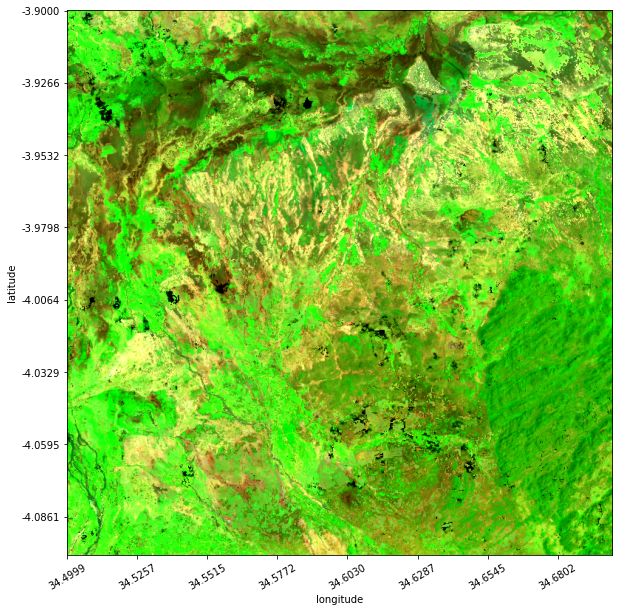

In [17]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

cleaned_dataset['NDVI'] = NDVI(cleaned_dataset)
max_ndvi_composite = create_min_max_var_mosaic(cleaned_dataset, cloud_mask, 
                                               var='NDVI', min_max='max')
rgb(max_ndvi_composite, **common_rgb_params)
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [18]:
# Remove the comment tags (#) to export a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

output_dir = 'output/geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
export_slice_to_geotiff(median_composite, output_dir + '/DEMO_median_composite.tif')
# export_slice_to_geotiff(geomedian_composite, output_dir + '/DEMO_geomedian_composite.tif')
# export_slice_to_geotiff(most_recent_composite, output_dir + '/DEMO_most_recent_composite.tif')
# export_slice_to_geotiff(max_ndvi_composite, output_dir + '/DEMO_max_ndvi_composite.tif')

In [19]:
!ls -lah output/geotiffs/

total 25M
drwxr-xr-x 3 jovyan users 4.0K Sep 29 14:39 .
drwxr-xr-x 4 jovyan users 4.0K Sep 28 15:25 ..
-rw-r--r-- 1 jovyan users  15M Sep 29 14:39 DEMO_median_composite.tif
-rw-r--r-- 1 jovyan users 371K Sep 29 00:53 WOFS_Percentage.tif
drwxr-xr-x 2 jovyan users 4.0K Sep 29 00:51 custom_mosaics
-rw-r--r-- 1 jovyan users 9.0M Sep 25 20:16 sample_anomaly_01.tif
-rw-r--r-- 1 jovyan users 470K Sep 29 00:53 wofs.tif
